In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import StandardScaler
from Scripts import to_stationary as ts

from matplotlib import font_manager

# Register Times New Roman font
font_path = 'C:/Users/taina/OneDrive/Documentos/GitHub/Previsao-de-Series-Temporais/Scripts/times.ttf'  # Replace with the actual path to the font file
font_manager.fontManager.addfont(font_path)

# Set font family to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

sns.set_style("whitegrid")


d:\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
d:\Anaconda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Set folders' path

processed_folder = 'C:/Users/taina/OneDrive/Documentos/GitHub/TimeSeries-Forecasting/ONS/processed_curves/'

if not os.path.exists(processed_folder):
    os.makedirs(processed_folder)

In [3]:
# Select region, "NORTE", "SUDESTE"
REGIAO = "SUDESTE"

# Importing

In [4]:
os.chdir('C:/Users/taina/OneDrive/Documentos/GitHub/TimeSeries-Forecasting/ONS/Dados ONS/')
df = pd.DataFrame()
for file in os.listdir():
    data = pd.read_excel(file)
    df = pd.concat([df,data], axis=0)
    
print(df.head())

  id_subsistema nom_subsistema din_instante  val_cargaenergiamwmed
0             N          NORTE   2000-01-01            2243.512500
1            NE       NORDESTE   2000-01-01            4646.370833
2             S            SUL   2000-01-01            4800.650000
3            SE        SUDESTE   2000-01-01           19045.995833
4             N          NORTE   2000-01-02            2259.808333


# Cleaning and defining functions

In [5]:
df = df[df['nom_subsistema'] == REGIAO]

# Find for any duplicated values
sum(df['din_instante'].duplicated())

# Drop unnecessary columns
df = df.drop(['id_subsistema','nom_subsistema'], axis=1)

df = df.rename(columns={'din_instante': 'data', 'val_cargaenergiamwmed': 'carga'})
df = df.dropna()
df = df[df['data'].dt.year >= 2002]
df = df.sort_values(by='data')
df = df.reset_index()
df = df.drop('index', axis=1)

if REGIAO == 'NORDESTE':
    df.loc[6068, 'carga'] = df.loc[6069, 'carga'] 
    

df.head()

,data,carga
0,2002-01-01,16802.182503
1,2002-01-02,21247.465833
2,2002-01-03,22630.834999
3,2002-01-04,22799.131665
4,2002-01-05,21167.087916


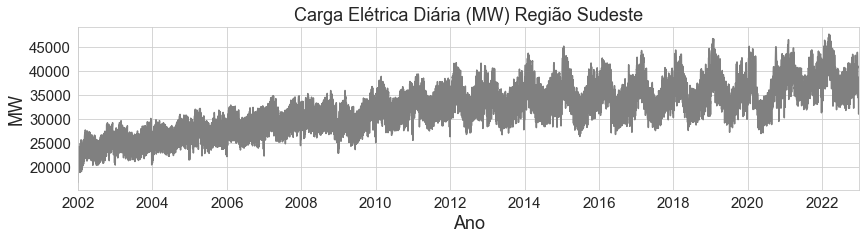

In [6]:
def draw_plot(df):
    # Draw Plot
    fig, ax = plt.subplots(figsize=(14,3))

    ax.plot('data', 'carga', data=df, color='gray')
    ax.set_title('Carga Elétrica Diária (MW) Região ' + REGIAO.title(), fontsize=18)
    ax.set_xlim(datetime.strptime('2002-01-01', '%Y-%m-%d'),datetime.strptime('2022-12-31', '%Y-%m-%d'))
    ax.set_ylabel('MW', fontsize=18)
    ax.set_xlabel('Ano', fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    
draw_plot(df)

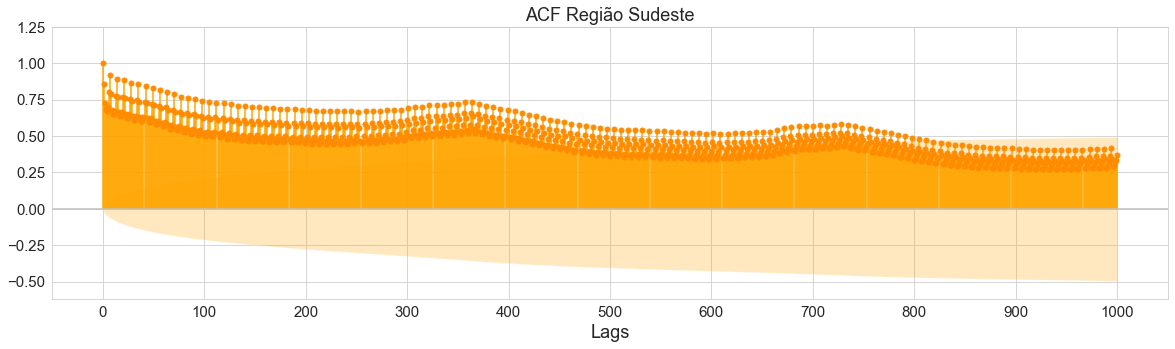

In [7]:
from matplotlib.collections import PolyCollection, LineCollection

# Autocorrelation function
def ACF(df):
    fig, ax = plt.subplots(figsize=(20,5))
    plot_acf(df['carga'], lags=1000, auto_ylims=True, ax=ax, color='darkorange')
    plt.title("ACF Região " + REGIAO.title(), fontsize=18)
    plt.xticks(range(0,1001,100), fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Lags", fontsize=18)
    ax.lines[0].set_color('silver')
    
    for item in ax.collections:
        if type(item)==PolyCollection:
            item.set_facecolor('orange')
        if type(item) == LineCollection:
            item.set_color('orange')
        
    plt.show()
    
    
    
ACF(df)

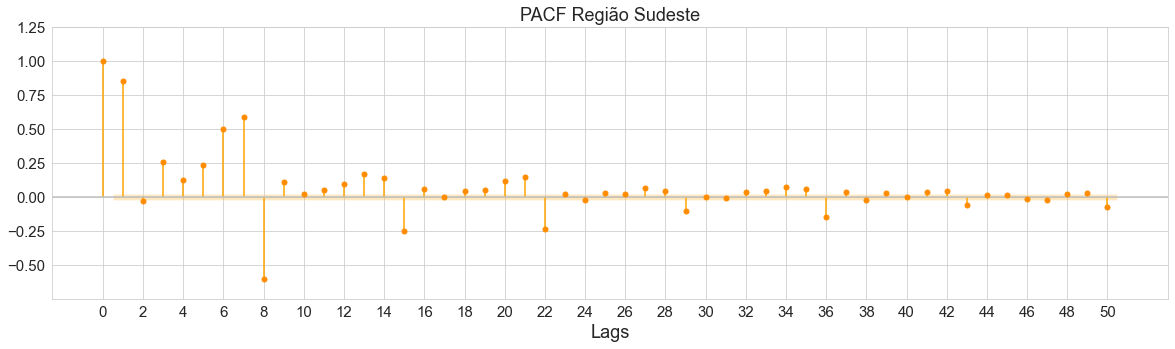

In [8]:
from matplotlib.collections import PolyCollection, LineCollection

# Autocorrelation function
def PACF(df):
    fig, ax = plt.subplots(figsize=(20,5))
    fig=plot_pacf(df['carga'], lags=50, auto_ylims=True, ax=ax, color='darkorange')
    plt.title("PACF Região " + REGIAO.title(), fontsize=18)
    plt.xticks(range(0,51,2), fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Lags", fontsize=18)
    ax.lines[0].set_color('silver')
    
    for item in ax.collections:
        if type(item)==PolyCollection:
            item.set_facecolor('orange')
        if type(item) == LineCollection:
            item.set_color('orange')
        
    plt.show()
    
PACF(df)

In [9]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller Test ->  Stationarity Test
def ADFtest(df):
    adft = adfuller(df['carga'], autolag='AIC')

    # Print ADF results
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    print(output['p-value'])

ADFtest(df)

0.01759137951816493


# 1 - Normalized series

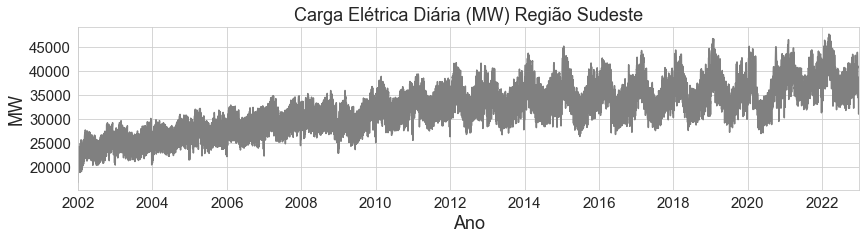

In [10]:
# Saving original series
df.to_pickle(processed_folder + 'df_' + REGIAO.lower() + '.pkl')

# Saving normalized series
df_norm = ts.normalize(df)
df_norm.to_pickle(processed_folder + 'df_norm_' + REGIAO.lower() + '.pkl')

draw_plot(df)



# 2 - Original series without trend by curve fitting




1.8401524586989019e-10


None

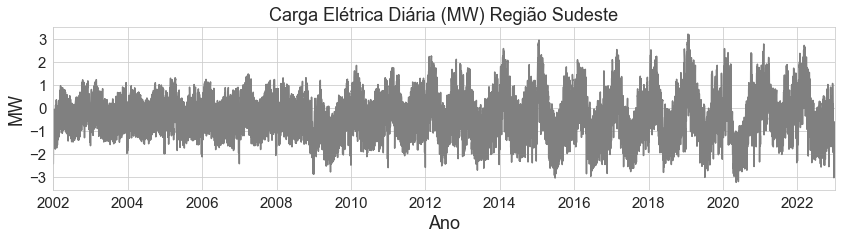

In [11]:
df_trend_fit, _ = ts.trend_fit_curve(df)
df_trend_fit = ts.normalize(df_trend_fit)


df_trend_fit.to_pickle(processed_folder + '/df_trend_fit_' + REGIAO.lower() + '.pkl')

draw_plot(df_trend_fit)
display(ADFtest(df_trend_fit))

# 3 - Original series without trend by differencing

0.0


None

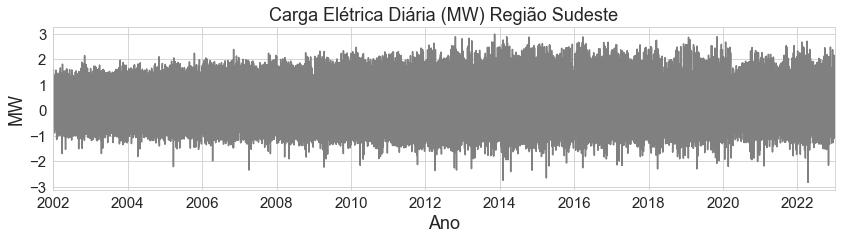

In [12]:
df_trend_diff = ts.trend_diff(df)
df_trend_diff = ts.normalize(df_trend_diff)

df_trend_diff.to_pickle(processed_folder + 'df_trend_diff_' + REGIAO.lower() + '.pkl')

draw_plot(df_trend_diff)
display(ADFtest(df_trend_diff))


# 4 - Original series without annual and weekly seasonality by normalization

Padronizado por cada dia do ano -> Ex: 01.01 

0.15555098071434204


None

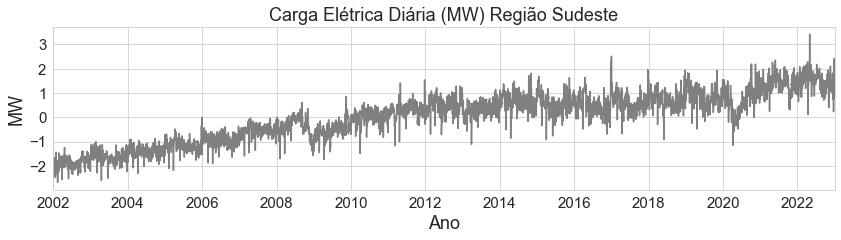

In [13]:
df_anual, _ , _ = ts.season_padronization(df, 'year')
df_desazon_pad, _ , _ = ts.season_padronization(df_anual, 'week')
df_desazon_pad.to_pickle(processed_folder + 'df_desazon_pad_' + REGIAO.lower() + '.pkl')

draw_plot(df_desazon_pad)
display(ADFtest(df_desazon_pad))

# 5 - Original series without annual and weekly seasonality by moving average

0.03135826737233902


None

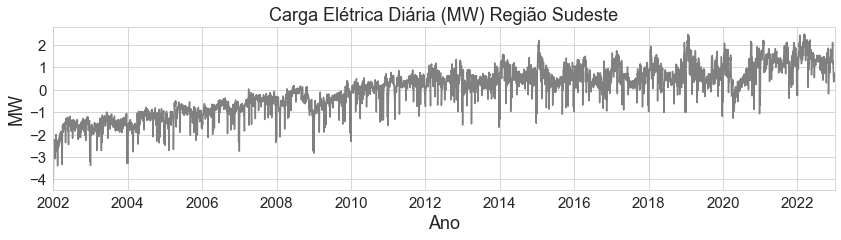

In [14]:
df_desazon_MA, _ = ts.season_MA(df, 'month')
df_desazon_MA, _ = ts.season_MA(df_desazon_MA, 'weekday')
df_desazon_MA = ts.normalize(df_desazon_MA)
df_desazon_MA.to_pickle(processed_folder + '/df_desazon_MA_' + REGIAO.lower() + '.pkl')
display(ADFtest(df_desazon_MA))
draw_plot(df_desazon_MA)

# 6 - Original Series without trend by curve fitting and without seasonality by normalization

2.239450266437247e-11


None

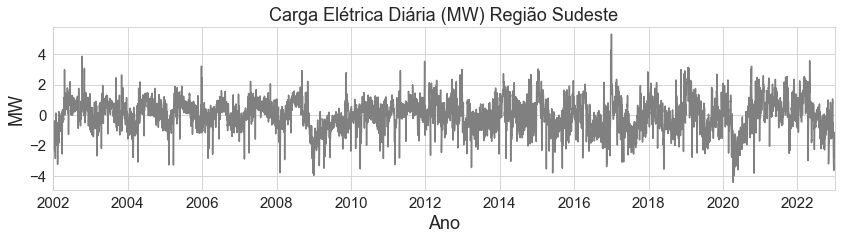

In [15]:
df_fit_pad, _ , _ = ts.season_padronization(df_trend_fit, 'year')
df_fit_pad, _ , _ = ts.season_padronization(df_fit_pad, 'week')

df_fit_pad.to_pickle(processed_folder + 'df_fit_pad_' + REGIAO.lower() + '.pkl')
display(ADFtest(df_fit_pad))
draw_plot(df_fit_pad)

# 7 - Original series without trend by curve fitting and without seasonality by moving average

5.737463399985467e-13


None

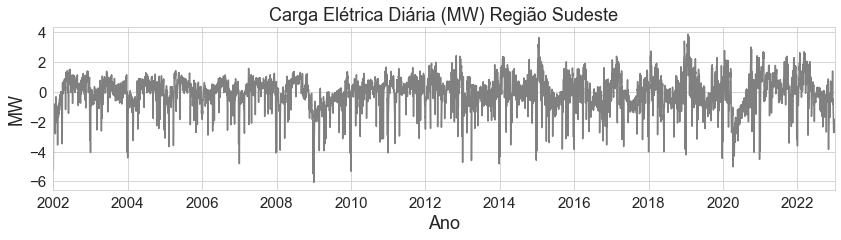

In [16]:
df_fit_MA, _ = ts.season_MA(df_trend_fit, 'month')
df_fit_MA, _ = ts.season_MA(df_fit_MA, 'weekday')
df_fit_MA = ts.normalize(df_fit_MA)

df_fit_MA.to_pickle(processed_folder + 'df_fit_MA_' + REGIAO.lower() + '.pkl')
display(ADFtest(df_fit_MA))
draw_plot(df_fit_MA)

# 8 - Original series without trend by differencing and without seasonality by normalization

7.616974294271604e-30


None

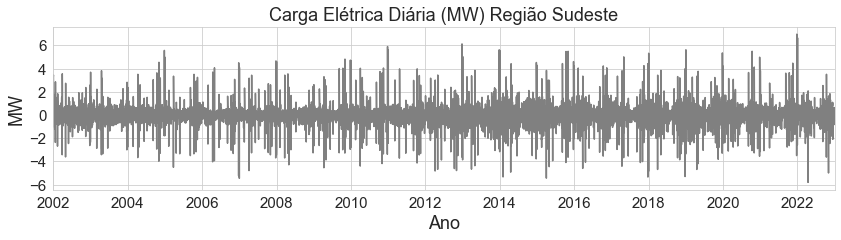

In [17]:
df_diff_pad, _ , _ = ts.season_padronization(df_trend_diff, 'week')
df_diff_pad.to_pickle(processed_folder + 'df_diff_pad_' + REGIAO.lower() + '.pkl')
display(ADFtest(df_diff_pad))
draw_plot(df_diff_pad)

# 9 - Original series without trend by differencing and without seasonality by moving average


0.0


None

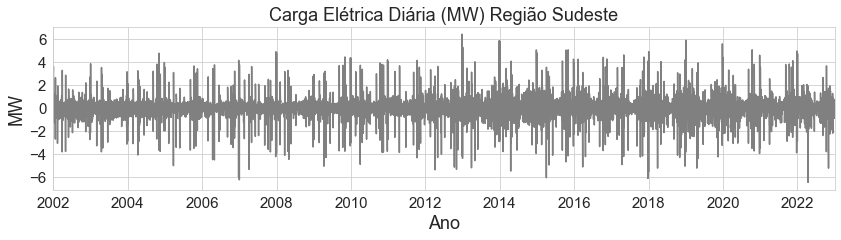

In [18]:
df_diff_MA, _ = ts.season_MA(df_trend_diff, 'weekday')
df_diff_MA = ts.normalize(df_diff_MA)

df_diff_MA.to_pickle(processed_folder + 'df_diff_MA_' + REGIAO.lower() + '.pkl')
display(ADFtest(df_diff_MA))

draw_plot(df_diff_MA)

# Analysis

In [19]:
import os

folder = 'C:/Users/taina/OneDrive/Documentos/GitHub/TimeSeries-Forecasting/ONS/processed_curves/'

# Get files from that region
pkl_dicts = {}
df_names = []
for pkl in os.listdir(folder):
    if (pkl.split('_')[-1][:-4] == REGIAO.lower()):
        pkl_dicts[pkl[:-4]] = pd.read_pickle(folder + pkl)
        df_names.append(pkl[:-4])

print(df_names)

# Set an id for each type of preprocessing method
ts_id = {'df_norm_sudeste': 1, 'df_trend_fit_sudeste': 2, 'df_trend_diff_sudeste': 3, 'df_desazon_MA_sudeste': 4, 'df_desazon_pad_sudeste': 5,
         'df_sudeste': 0, 'df_fit_MA_sudeste': 6, 'df_fit_pad_sudeste': 7, 'df_diff_MA_sudeste': 8, 'df_diff_pad_sudeste': 9}

['df_desazon_MA_sudeste', 'df_desazon_pad_sudeste', 'df_diff_MA_sudeste', 'df_diff_pad_sudeste', 'df_fit_MA_sudeste', 'df_fit_pad_sudeste', 'df_norm_sudeste', 'df_sudeste', 'df_trend_diff_sudeste', 'df_trend_fit_sudeste']


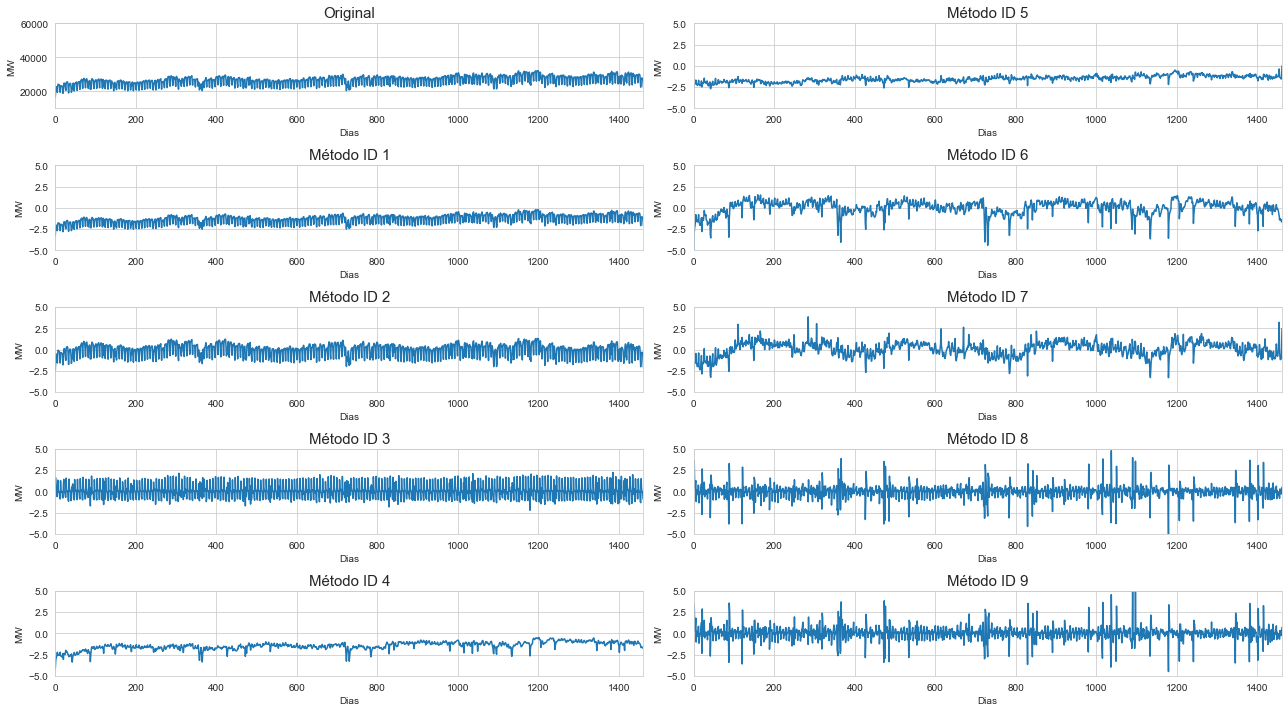

In [20]:
# Plot each transformed series

sns.set_style("whitegrid")

fig, axs = plt.subplots(5, 2, figsize=(18, 10))
for i, item in enumerate(pkl_dicts.values()):
    item_id = ts_id[list(pkl_dicts.keys())[i]]
    ax = axs[item_id%5][0 if (item_id<5) else 1]
    chart = sns.lineplot(data=item, x=item.index, y='carga', ax=ax)
    chart.set_xlim(0,len(data))
    chart.set_ylabel('MW')
    chart.set_xlabel('Dias')


    if item_id > 0:
        chart.set_title('Método ID ' + str(item_id), fontsize=15)
        chart.set_ylim([-5,5])
    else:
      chart.set_title('Original', fontsize=15)
      chart.set_ylim([10000, 60000])

#fig.delaxes(axs[4][1])
plt.tight_layout()
plt.show()

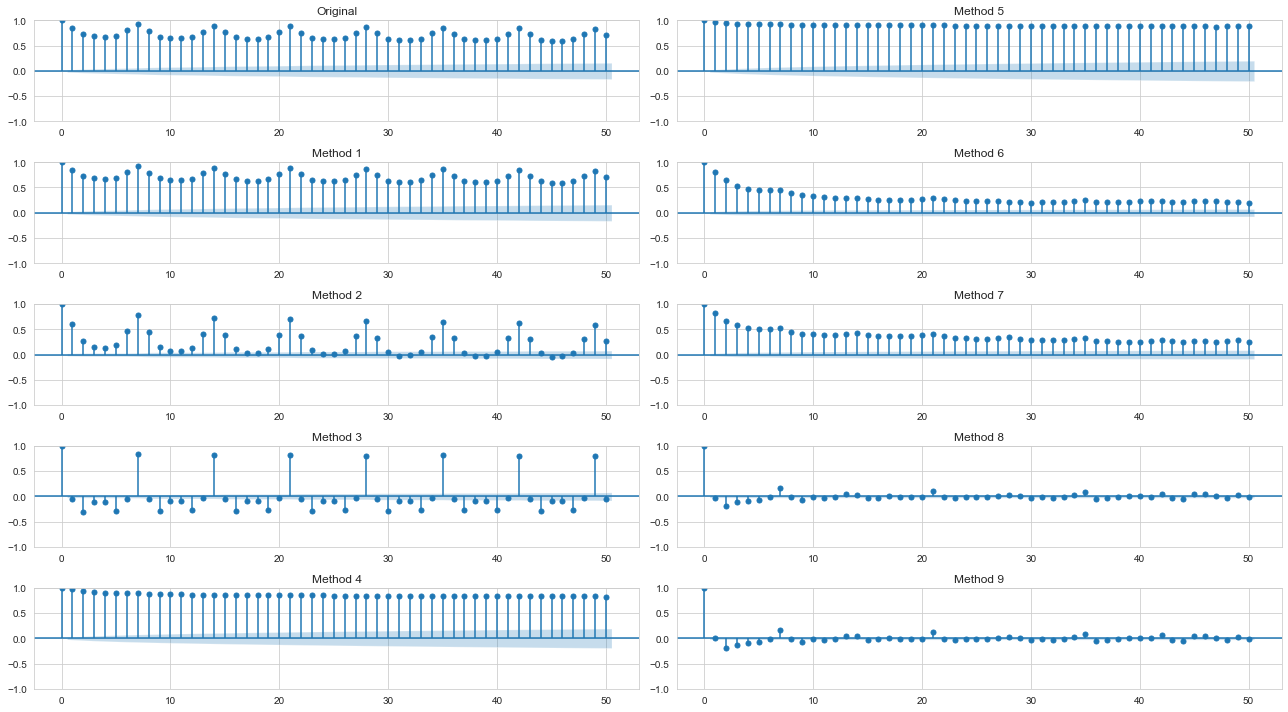

In [21]:
# Plot ACF from each transformed series

from statsmodels.graphics.tsaplots import plot_acf

fig, axs = plt.subplots(5, 2, figsize=(18, 10))
for i, item in enumerate(pkl_dicts.values()):
    item_id = ts_id[list(pkl_dicts.keys())[i]]
    ax = axs[item_id%5][0 if (item_id<5) else 1]
    ax.xlim=([0,50])
    plot_acf(item['carga'], lags=50, ax=ax)


    if item_id != 0:
        ax.set_title('Method ' + str(item_id))
    else:
        ax.set_title('Original')

plt.tight_layout()
plt.show()